# Bias and Variance

Every estimator has its advantages and drawbacks. Its generalization error can be decomposed in terms of bias, variance and noise. The **bias** of an estimator is its average error for different training sets. The **variance** of an estimator indicates how sensitive it is to varying training sets. Noise is a property of the data.

## Underfit vs Overfit
Roughly speaking, **underfit** means the model is not sufficient to fit the training samples, and **overfit** means that the models learns too many noise from the data. In many cases, high bias is related to underfit, and high variance is related to overfit.

The following example is from [the `sklearn` guide](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py). Although it is a polynomial regression example, it grasps the key idea of underfit and overfit.

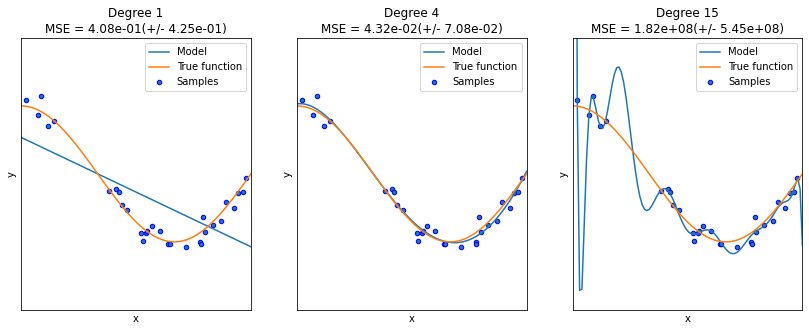

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)


np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline(
        [
            ("polynomial_features", polynomial_features),
            ("linear_regression", linear_regression),
        ]
    )
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(
        pipeline, X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10
    )

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor="b", s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title(
        "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
            degrees[i], -scores.mean(), scores.std()
        )
    )
plt.show()

## Learning curves

A learning curve shows the validation and training score of an estimator for varying a key hyperparameter. In most cases the key hyperparameter is the sample size of the number of iterations. It is a tool to find out how much we benefit from altering the hyperparameter by adding more training data or training for more iterations, and whether the estimator suffers more from a variance error or a bias error. 

`sklearn` provides `sklearn.model_selection.learning_curve()` to generate the values that are required to plot such a learning curve. However this function is just related to the sample size. If we would like to talk about epochs, we need other packages.

## Using 
